In [336]:
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.cluster import KMeans
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from collections import OrderedDict
from sklearn.decomposition import LatentDirichletAllocation  as LDA
import pickle

In [80]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sarit/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [337]:
#msg_df_all = pd.read_csv("repo_comments.csv",error_bad_lines=False,delimiter=';')
#msg_df_all = pd.read_csv("repository_messages_gt_500.csv",error_bad_lines=False,delimiter=',')
msg_df_all = pd.read_csv("repository_messages_all.csv",error_bad_lines=False,delimiter=',')
msg_df_all

,repo_group_id,repo_id,repo_git,repo_name,thread_id,msg_text,thread_title,msg_id
0,25157,25663,https://github.com/Spring-projects/spring-fram...,spring-framework,554893,"Awesome, @jhoeller! It's great to see the last...",Fix typo in webmvc-functional.adoc,2035038
1,25186,30039,https://github.com/bitnami/charts,charts,556333,\nI have just updated the bitnami images with ...,[bitnami/redis-cluster]appendonly is true in r...,2079399
2,25157,25760,https://github.com/Spring-projects/spring-boot,spring-boot,523090,Thanks,Disable auto-configuration of Hazelcast IMDG w...,1904151
3,25179,27215,https://github.com/pivotal-cf/docs-rabbitmq-pcf,docs-rabbitmq-pcf,553473,Hi @albertoleal Thanks v much for kicking off ...,Docs for prometheus and rolling upgrade checks,2023561
4,25157,25730,https://github.com/Spring-projects/spring-ide,spring-ide,232340,"Hi Martin,\n\nI've just applied the changes yo...",IDE-1370: Updating Spring Roo plugin to work w...,1735594
...,...,...,...,...,...,...,...,...
427851,25159,25857,https://github.com/greenplum-db/gpdb,gpdb,526219,"LGTM, and all good to squash when merging.",removed wrong errormsg which shows on Windows ...,1922981
427852,25184,28150,https://github.com/goharbor/harbor,harbor,301969,## Pull Request Test Coverage Report for [Buil...,[cherry-pick]ignore the duplicate error when t...,1951488
427853,25155,25432,https://github.com/rabbitmq/rabbitmq-server,rabbitmq-server,399152,Do we still need this read?,enabled_plugins file should be stored in /var/...,2020617
427854,25184,28150,https://github.com/goharbor/harbor,harbor,542162,"@jcmartins, you must sign our contributor lice...",Add vulneraibility case,1981398


In [338]:
msg_df_all = msg_df_all.groupby("repo_id").filter(lambda x: len(x)>500) 

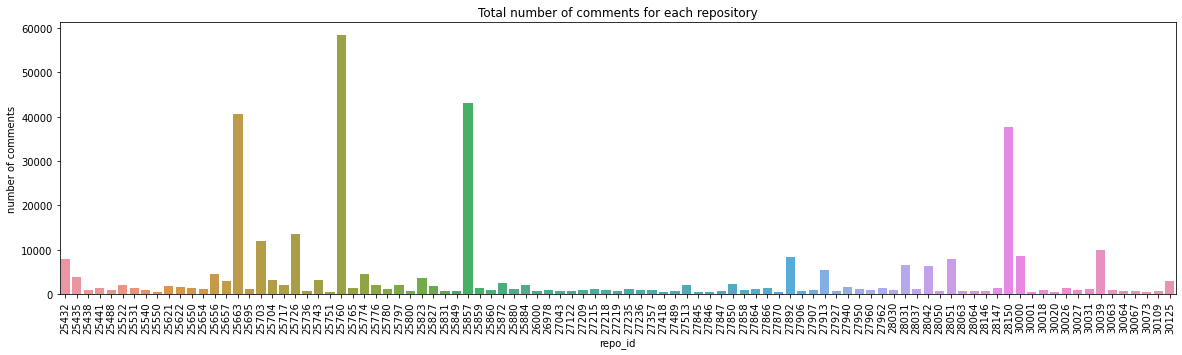

In [339]:
plt.subplots(figsize=(20,5))
repo_msg_barplot = sns.countplot(x="repo_id", data=msg_df_all)
repo_msg_barplot.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
plt.title("Total number of comments for each repository")
plt.xlabel("repo_id")
plt.ylabel("number of comments")
print()

In [340]:
msg_df = msg_df_all.groupby('repo_id')['msg_text'].apply(','.join)
msg_df = msg_df.reset_index()
msg_df

,repo_id,msg_text
0,25432,The patch is working for me locally (after bui...
1,25435,Thanks for confirming my hypothesis @lukebakke...
2,25438,Changes made and moved to 4.x.x branch on #346...
3,25441,"Hi Simon, this seems to correlate with what Si..."
4,25488,Would it improve the situation to write out al...
...,...,...
92,30064,"Well, there could also be other variables that..."
93,30067,Don't worry. I found the instructions on the ...
94,30073,"Hi @andresbono, thanks for your review.\r\nI a..."
95,30109,"> to force it to use embedded lib\r\n\r\nOh, i..."


In [341]:
message_desc_df = msg_df_all[["repo_id","repo_git","repo_name","msg_id"]].groupby(["repo_id","repo_git","repo_name"]).agg('count').reset_index()
message_desc_df.columns = ["repo_id","repo_git", "repo_name", "message_count"]
#msg_df_desc = msg_df_all[["repo_id", "repo_git","repo_name"]].groupby("repo_id").reset_index().set_index('repo_id').join(message_count_df.set_index('repo_id')).reset_index()
message_desc_df

,repo_id,repo_git,repo_name,message_count
0,25432,https://github.com/rabbitmq/rabbitmq-server,rabbitmq-server,7878
1,25435,https://github.com/rabbitmq/rabbitmq-dotnet-cl...,rabbitmq-dotnet-client,3836
2,25438,https://github.com/rabbitmq/rabbitmq-java-client,rabbitmq-java-client,800
3,25441,https://github.com/rabbitmq/rabbitmq-management,rabbitmq-management,1461
4,25488,https://github.com/rabbitmq/chef-cookbook,chef-cookbook,981
...,...,...,...,...
92,30064,https://github.com/bitnami/bitnami-docker-magento,bitnami-docker-magento,668
93,30067,https://github.com/bitnami/bitnami-docker-phab...,bitnami-docker-phabricator,629
94,30073,https://github.com/bitnami/bitnami-docker-suit...,bitnami-docker-suitecrm,527
95,30109,https://github.com/bitnami/kubecfg,kubecfg,653


In [342]:
def preprocess_and_tokenize(text):
    text= text.lower()
    text =  re.sub(r'[@]\w+','',text)
    text =  re.sub(r'[^A-Za-z]+', ' ', text)
    
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if len(token)>1]
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [343]:
def get_tf_idf_matrix(text_list, max_df, max_features, min_df, ngram_range):
    tfidf_vectorizer = TfidfVectorizer(max_df = max_df, max_features=max_features,
                                      min_df=min_df, stop_words='english',
                                      use_idf=True, tokenizer=preprocess_and_tokenize, ngram_range=ngram_range)
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_list)
    return tfidf_matrix, tfidf_vectorizer.get_feature_names()

In [344]:
def cluster_and_label(feature_matrix, num_clusters):
    kmeans_model = KMeans(n_clusters=NUM_CLUSTERS)
    kmeans_model.fit(feature_matrix)
    return kmeans_model.labels_.tolist()

In [345]:
def visualize_labels_PCA(features, labels, annotations, num_components, title):
    
    labels_color_map = {-1 : "red"}
    for label in labels:
        labels_color_map[label] = [list([x/255.0 for x in list(np.random.choice(range(256), size=3))])]
    low_dim_data = PCA(n_components=num_components).fit_transform(features)

    fig, ax = plt.subplots(figsize=(20,10))

    for i, data in enumerate(low_dim_data):
        pca_comp_1, pca_comp_2 = data
        color = labels_color_map[labels[i]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color,label=labels[i])
        #ax.annotate(annotations[i],(pca_comp_1, pca_comp_2))
        
    
    handles,labels = ax.get_legend_handles_labels()
    handles_label_dict = OrderedDict(zip(labels, handles))
    ax.legend(handles_label_dict.values(), handles_label_dict.keys() )
    
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

In [346]:
MAX_DF = 0.9
MAX_FEATURES = 1000 
MIN_DF = 0.1 
NGRAM_RANGE = (1,3)
NUM_CLUSTERS = 4

In [ ]:
tfidf_matrix, features = get_tf_idf_matrix(msg_df['msg_text'], MAX_DF, MAX_FEATURES, MIN_DF, NGRAM_RANGE)

/home/sarit/.virtualenvs/augur_env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [289]:
msg_df['cluster'] = cluster_and_label(tfidf_matrix, NUM_CLUSTERS)

In [290]:
msg_df

,repo_id,msg_text,cluster
0,25432,The patch is working for me locally (after bui...,0
1,25435,Thanks for confirming my hypothesis @lukebakke...,0
2,25438,Changes made and moved to 4.x.x branch on #346...,0
3,25441,"Hi Simon, this seems to correlate with what Si...",0
4,25488,Would it improve the situation to write out al...,0
...,...,...,...
92,30064,"Well, there could also be other variables that...",3
93,30067,Don't worry. I found the instructions on the ...,3
94,30073,"Hi @andresbono, thanks for your review.\r\nI a...",3
95,30109,"> to force it to use embedded lib\r\n\r\nOh, i...",3


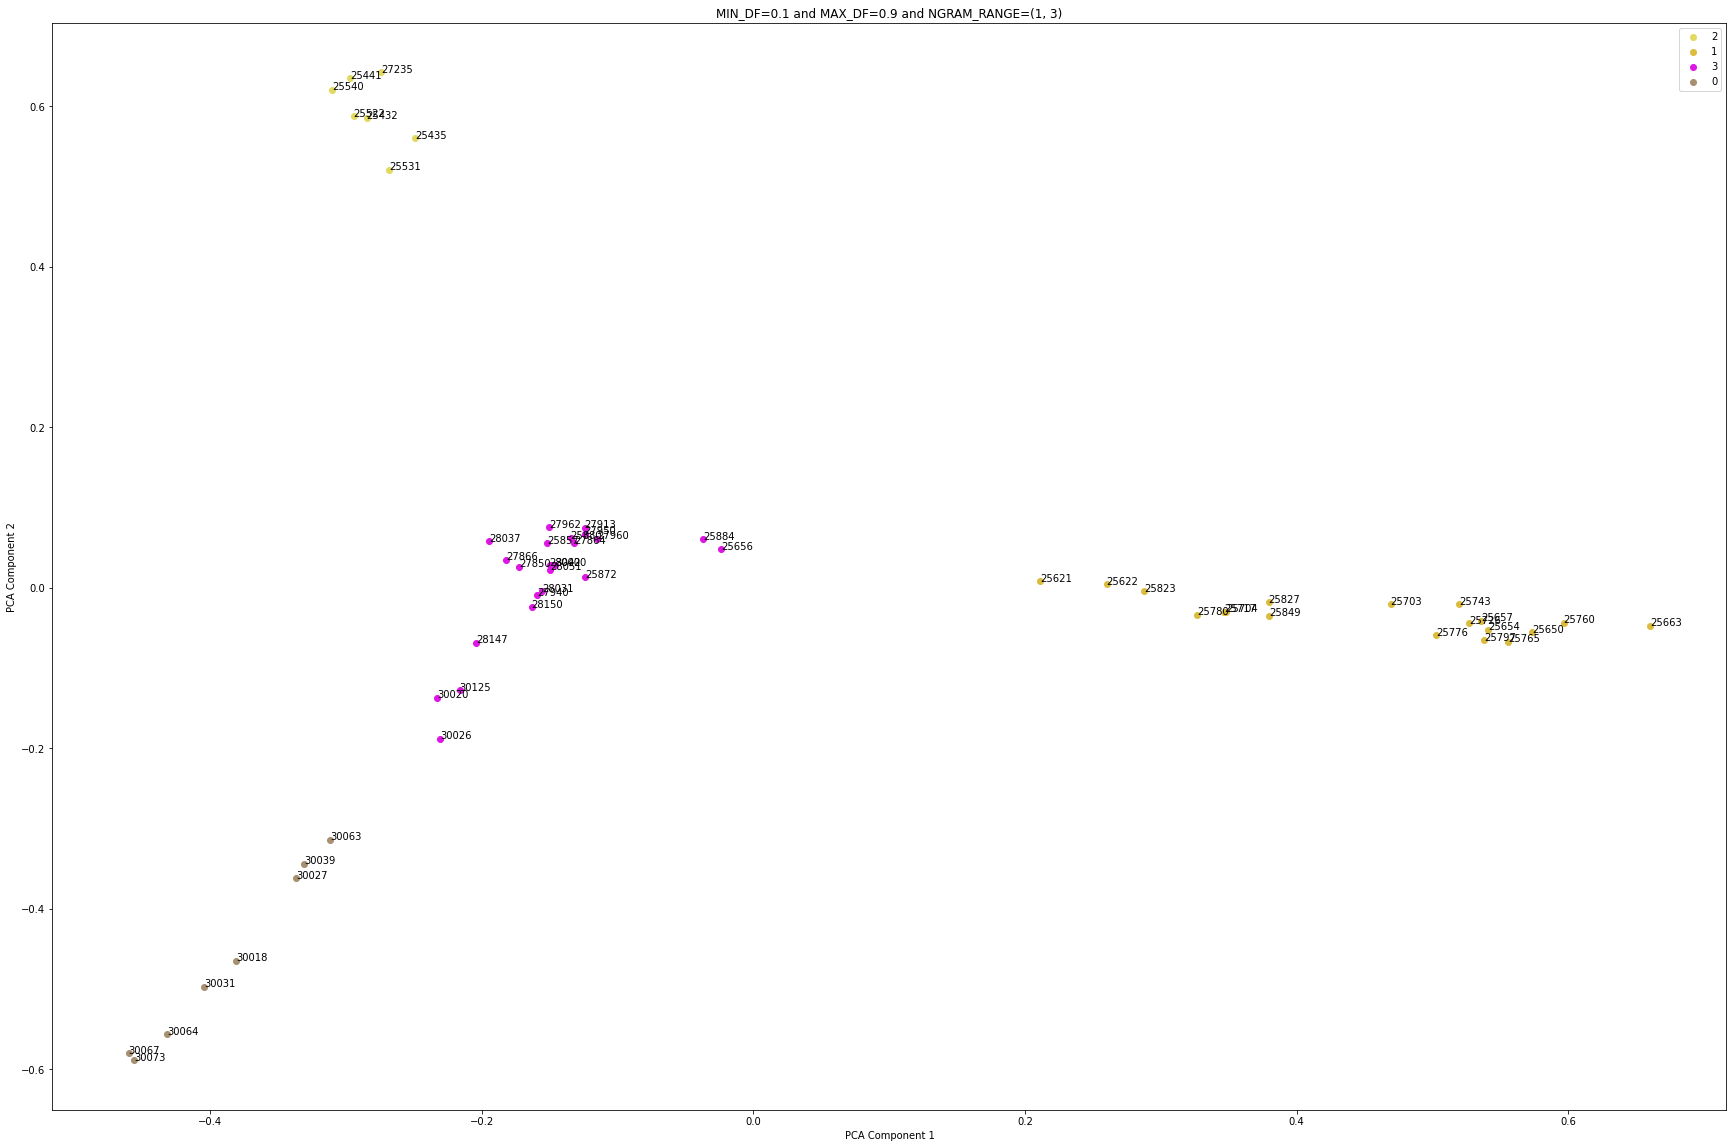

In [199]:

visualize_labels_PCA(tfidf_matrix.todense(), msg_df['cluster'], msg_df['repo_id'], 2, "MIN_DF={} and MAX_DF={} and NGRAM_RANGE={}".format(MIN_DF, MAX_DF, NGRAM_RANGE))

In [273]:
count_vectorizer = CountVectorizer(max_df=MAX_DF, max_features=MAX_FEATURES, min_df=MIN_DF,stop_words="english", tokenizer=preprocess_and_tokenize)
count_matrix = count_vectorizer.fit_transform(msg_df['msg_text'])
#print(count_matrix)
feature_names = count_vectorizer.get_feature_names()

/home/sarit/.virtualenvs/augur_env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [286]:
lda_model = LDA(n_components=5)
lda_model.fit(count_matrix)
# each component in lda_model.components_ represents probability distribution over words in that topic
topic_list = lda_model.components_
print(topic_list)
num_words = 10
topic_num = 1
for topic in topic_list:
    print("\nTopic {}".format(topic_num))
    for i in topic.argsort()[:-num_words-1:-1]:
        print(feature_names[i])
    topic_num+=1
prediction = lda_model.transform(count_matrix)

topic_model_dict_list = []
for i, prob_vector in enumerate(prediction):
    topic_model_dict = {}
    print("Repo: {}".format(msg_df.loc[i]['repo_id']))
    topic_model_dict['repo_id'] = msg_df.loc[i]['repo_id']
    print(" ".join([ str(round(prob*100,2))+"% topic"+str(i+1) for i,prob in enumerate(prob_vector)]))
    for i, prob in enumerate(prob_vector):
        topic_model_dict["topic"+str(i+1)] = prob
        
    topic_model_dict_list.append(topic_model_dict)
topic_model_dict_list
topic_model_df = pd.DataFrame(topic_model_dict_list) 


[[8.84329022e+02 4.32326494e+02 1.19321720e+02 ... 3.69129324e+01
  7.22713437e+02 7.72116373e+01]
 [1.24307742e+03 9.93748684e+02 7.12472977e+02 ... 3.47346030e+02
  7.22610862e+02 1.26099081e+02]
 [1.91853801e+02 9.17437740e+01 1.05596758e+02 ... 1.72795748e+02
  7.73565977e-01 5.75071596e+01]
 [7.39965931e+02 6.17994850e+02 8.85456803e+00 ... 6.09592408e+02
  3.10944382e+02 5.98202111e+02]
 [1.83077383e+03 1.36618620e+03 4.07539779e+01 ... 3.73528819e+01
  8.01957753e+02 1.03980011e+02]]

Topic 1
bitnami
mariadb
backup
stori
mongodb
resourc
pivot
tracker
docker
restor

Topic 2
tabl
vmware
sign
concours
pipelin
command
src
pg
cla
row

Topic 3
rabbitmq
pivot
xx
channel
rabbit
amqp
cach
integr
spring
cla

Topic 4
spring
java
boot
springframework
class
method
secur
framework
jar
cla

Topic 5
src
coverag
harbor
diff
gh
el
tree
vmware
badg
relev
Repo: 25432
0.02% topic1 23.28% topic2 76.7% topic3 0.0% topic4 0.0% topic5
Repo: 25435
0.0% topic1 35.61% topic2 57.98% topic3 5.82% topic4 0.59

In [295]:
result_content_df = topic_model_df.set_index('repo_id').join(message_desc_df.set_index('repo_id')).join(msg_df.set_index('repo_id'))
result_content_df = result_content_df.reset_index()
result_content_df
#message_desc_df
#msg_df

,repo_id,topic1,topic2,topic3,topic4,topic5,repo_git,repo_name,message_count,msg_text,cluster
0,25432,0.000200,0.232830,0.766962,0.000004,0.000004,https://github.com/rabbitmq/rabbitmq-server,rabbitmq-server,7878,The patch is working for me locally (after bui...,0
1,25435,0.000009,0.356092,0.579795,0.058208,0.005896,https://github.com/rabbitmq/rabbitmq-dotnet-cl...,rabbitmq-dotnet-client,3836,Thanks for confirming my hypothesis @lukebakke...,0
2,25438,0.002552,0.046081,0.667407,0.283929,0.000031,https://github.com/rabbitmq/rabbitmq-java-client,rabbitmq-java-client,800,Changes made and moved to 4.x.x branch on #346...,0
3,25441,0.015947,0.283143,0.656669,0.004216,0.040025,https://github.com/rabbitmq/rabbitmq-management,rabbitmq-management,1461,"Hi Simon, this seems to correlate with what Si...",0
4,25488,0.132478,0.403510,0.382264,0.071573,0.010175,https://github.com/rabbitmq/chef-cookbook,chef-cookbook,981,Would it improve the situation to write out al...,0
...,...,...,...,...,...,...,...,...,...,...,...
92,30064,0.893554,0.034316,0.035593,0.036524,0.000013,https://github.com/bitnami/bitnami-docker-magento,bitnami-docker-magento,668,"Well, there could also be other variables that...",3
93,30067,0.887468,0.093054,0.000015,0.000015,0.019448,https://github.com/bitnami/bitnami-docker-phab...,bitnami-docker-phabricator,629,Don't worry. I found the instructions on the ...,3
94,30073,0.923722,0.076239,0.000013,0.000013,0.000013,https://github.com/bitnami/bitnami-docker-suit...,bitnami-docker-suitecrm,527,"Hi @andresbono, thanks for your review.\r\nI a...",3
95,30109,0.244998,0.681606,0.004090,0.019595,0.049711,https://github.com/bitnami/kubecfg,kubecfg,653,"> to force it to use embedded lib\r\n\r\nOh, i...",3


In [63]:
!pip install TextBlob

     |████████████████████████████████| 645kB 3.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [297]:
from textblob import TextBlob
from collections import Counter

In [83]:

print(counts)

Counter({'DT': 6, 'NN': 5, 'IN': 5, 'NNS': 4, 'CC': 3, 'VBZ': 2, 'JJ': 2, 'NNP': 2, 'PRP': 1, 'MD': 1, 'VB': 1, 'VBN': 1, 'VBG': 1})


In [298]:
def count_func(msg):
    blobed = TextBlob(msg)
    counts = Counter(tag for word,tag in blobed.tags if tag not in ['NNPS','RBS','SYM','WP$','LS','POS','RP','RBR','JJS','UH','FW','PDT'])
    total = sum(counts.values())
    normalized_count = {key: value/total for key,value in counts.items()}
    return normalized_count

In [299]:
POS_count_dict = msg_df.apply(lambda row : count_func(row['msg_text']), axis = 1)
POS_count_dict

0     {'DT': 0.09155903165093954, 'NN': 0.1858529043...
1     {'NNS': 0.03390555936001992, 'IN': 0.091538006...
2     {'NNS': 0.038473029045643155, 'VBN': 0.0205145...
3     {'NNP': 0.14534928010969758, 'DT': 0.070693989...
4     {'MD': 0.02335282810518997, 'PRP': 0.064578135...
                            ...                        
92    {'RB': 0.04223797597317146, 'EX': 0.0021225113...
93    {'VBP': 0.022579829808745473, 'RB': 0.03875642...
94    {'NNP': 0.17597183450689555, 'NN': 0.232656972...
95    {'NN': 0.19345516362090948, 'TO': 0.0316192095...
96    {'NN': 0.1919789393005315, 'NNP': 0.0915740540...
Length: 97, dtype: object

In [300]:
msg_df_aug = pd.concat([msg_df,pd.DataFrame.from_records(POS_count_dict)], axis=1)
msg_df_aug

,repo_id,msg_text,cluster,DT,NN,VBZ,VBG,IN,PRP,RB,...,VB,VBN,WDT,CC,EX,MD,WRB,PRP$,JJR,WP
0,25432,The patch is working for me locally (after bui...,0,0.091559,0.185853,0.039502,0.020186,0.097167,0.051626,0.058663,...,0.067863,0.021840,0.005965,0.022546,0.003428,0.027611,0.005414,0.004376,0.003243,0.002545
1,25435,Thanks for confirming my hypothesis @lukebakke...,0,0.100954,0.171255,0.034341,0.027984,0.091538,0.055882,0.059072,...,0.063072,0.022225,0.005354,0.020575,0.002910,0.026762,0.006210,0.007190,0.003338,0.002918
2,25438,Changes made and moved to 4.x.x branch on #346...,0,0.100614,0.191801,0.041726,0.021012,0.096066,0.049129,0.056664,...,0.055801,0.020515,0.005378,0.023602,0.001660,0.022407,0.008664,0.004515,0.004282,0.002490
3,25441,"Hi Simon, this seems to correlate with what Si...",0,0.070694,0.213809,0.031589,0.018638,0.077042,0.050024,0.046520,...,0.048399,0.016505,0.003631,0.016962,0.002717,0.016734,0.005688,0.004317,0.002235,0.003479
4,25488,Would it improve the situation to write out al...,0,0.095252,0.198029,0.031451,0.019917,0.088953,0.064578,0.051573,...,0.061715,0.020081,0.003640,0.022862,0.002208,0.023353,0.003804,0.006421,0.002168,0.002413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,30064,"Well, there could also be other variables that...",3,0.075837,0.215414,0.024239,0.020737,0.077387,0.052893,0.042238,...,0.052808,0.016810,0.002780,0.017107,0.002123,0.017362,0.004712,0.007195,0.000998,0.001592
93,30067,Don't worry. I found the instructions on the ...,3,0.070288,0.220448,0.025192,0.018831,0.073026,0.050110,0.038756,...,0.047076,0.018725,0.002022,0.017714,0.001411,0.013923,0.003012,0.005961,0.001474,0.001369
94,30073,"Hi @andresbono, thanks for your review.\r\nI a...",3,0.063768,0.232657,0.023207,0.018520,0.065393,0.040165,0.032665,...,0.041373,0.015874,0.002646,0.016103,0.000896,0.011166,0.002604,0.005541,0.001312,0.001229
95,30109,"> to force it to use embedded lib\r\n\r\nOh, i...",3,0.101629,0.193455,0.036917,0.023318,0.102507,0.062218,0.064287,...,0.065987,0.017935,0.006205,0.021703,0.002833,0.022808,0.005015,0.003995,0.002068,0.004675


In [301]:
filepath = "NRC-Emotion-Lexicon.txt"
emotion_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')

In [302]:
anger_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'anger')].word.tolist()
surprise_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'surprise')].word.tolist()
anticipation_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'anticipation')].word.tolist()
disgust_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'disgust')].word.tolist()
fear_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'fear')].word.tolist()
joy_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'joy')].word.tolist()
sadness_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'sadness')].word.tolist()
trust_words = emotion_df[(emotion_df.association == 1) & (emotion_df.emotion == 'trust')].word.tolist()

In [303]:
def emotion_count(text):
    count_dict = {'anger': 0 , 'surprise' : 0 , 'anticipation' : 0, 'disgust' : 0, 'fear' : 0, 'joy' : 0, 'sadness': 0, 'trust':0}
    tokens = preprocess_and_tokenize(text)
    for token in tokens:
        if token in anger_words:
            count_dict['anger'] +=1
        if token in surprise_words:
            count_dict['surprise'] +=1
        if token in anticipation_words:
            count_dict['anticipation'] +=1
        if token in disgust_words:
            count_dict['disgust'] +=1
        if token in fear_words:
            count_dict['fear'] +=1
        if token in joy_words:
            count_dict['joy'] +=1
        if token in sadness_words:
            count_dict['sadness'] +=1
        if token in trust_words:
            count_dict['trust'] +=1
            
    normalized_count = {key: value/sum(count_dict.values()) for key,value in count_dict.items()}
    return normalized_count

In [110]:
emotion_count("The KNIME Deep Learning Extension integrates deep learning functionalities, networks and architectures from TensorFlow and Keras in Python. Even though this extension allows you to write Python code to run the TensorFlow/Keras libraries, it also allows you to assemble, train and apply Keras networks through the traditional KNIME Graphical User Interface, based on nodes, drag and drops, clicks, configuration windows, and traffic light status. This last option makes the whole assembling and training process codeless and, therefore, much easier and faster, especially for prototyping and experimentation. A mix and match approach is also possible.")

{'anger': 0,
 'surprise': 1,
 'anticipation': 3,
 'disgust': 0,
 'fear': 0,
 'joy': 0,
 'sadness': 0,
 'trust': 1}

In [304]:
temp_dict = msg_df.apply(lambda row : emotion_count(row['msg_text']), axis = 1)
temp_dict

0     {'anger': 0.05755700153414802, 'surprise': 0.0...
1     {'anger': 0.03861671469740634, 'surprise': 0.0...
2     {'anger': 0.038594969644405897, 'surprise': 0....
3     {'anger': 0.023175696836830566, 'surprise': 0....
4     {'anger': 0.037037037037037035, 'surprise': 0....
                            ...                        
92    {'anger': 0.06029637199795605, 'surprise': 0.0...
93    {'anger': 0.0770935960591133, 'surprise': 0.09...
94    {'anger': 0.05142383190489356, 'surprise': 0.0...
95    {'anger': 0.051489637305699484, 'surprise': 0....
96    {'anger': 0.05025794641371276, 'surprise': 0.1...
Length: 97, dtype: object

In [313]:
msg_df_aug_emo = pd.concat([msg_df_aug,pd.DataFrame.from_records(temp_dict)], axis=1)
#msg_df_aug_emo.isna().any()
#msg_df_aug_emo = msg_df_aug_emo.dropna(axis='columns')
msg_df_aug_emo_sub = msg_df_aug_emo[:20]
msg_df_aug_emo_sub

,repo_id,msg_text,cluster,DT,NN,VBZ,VBG,IN,PRP,RB,...,JJR,WP,anger,surprise,anticipation,disgust,fear,joy,sadness,trust
0,25432,The patch is working for me locally (after bui...,0,0.091559,0.185853,0.039502,0.020186,0.097167,0.051626,0.058663,...,0.003243,0.002545,0.057557,0.079670,0.216844,0.069566,0.146273,0.077131,0.158335,0.194625
1,25435,Thanks for confirming my hypothesis @lukebakke...,0,0.100954,0.171255,0.034341,0.027984,0.091538,0.055882,0.059072,...,0.003338,0.002918,0.038617,0.065706,0.234236,0.045072,0.118386,0.093141,0.114352,0.290490
2,25438,Changes made and moved to 4.x.x branch on #346...,0,0.100614,0.191801,0.041726,0.021012,0.096066,0.049129,0.056664,...,0.004282,0.002490,0.038595,0.077624,0.217693,0.063747,0.168690,0.064180,0.136600,0.232871
3,25441,"Hi Simon, this seems to correlate with what Si...",0,0.070694,0.213809,0.031589,0.018638,0.077042,0.050024,0.046520,...,0.002235,0.003479,0.023176,0.057626,0.211713,0.025368,0.094895,0.158472,0.102412,0.326339
4,25488,Would it improve the situation to write out al...,0,0.095252,0.198029,0.031451,0.019917,0.088953,0.064578,0.051573,...,0.002168,0.002413,0.037037,0.073593,0.153920,0.127946,0.173160,0.094276,0.160173,0.179894
5,25522,"@michaelklishin OK, I'll wait for my PR at rab...",0,0.083812,0.195871,0.032017,0.015099,0.074455,0.045609,0.056540,...,0.001042,0.001330,0.012138,0.024552,0.102069,0.053517,0.059862,0.043034,0.051586,0.653241
6,25531,These can be destructured right in the functio...,0,0.083286,0.194388,0.037214,0.025635,0.090557,0.062768,0.064706,...,0.002962,0.001993,0.033158,0.078135,0.160210,0.057124,0.142482,0.091596,0.147406,0.289888
7,25540,I'm going to give it another try by making it ...,0,0.086290,0.191389,0.037484,0.022419,0.083571,0.053753,0.055357,...,0.001203,0.003566,0.031281,0.064052,0.135551,0.105760,0.183217,0.096326,0.154419,0.229394
8,25550,"Interesting, the official docs use a global va...",0,0.100153,0.191098,0.041292,0.014404,0.095859,0.061007,0.061684,...,0.002881,0.001469,0.068789,0.109721,0.146106,0.069926,0.189312,0.043206,0.178511,0.194429
9,25621,"@unscriptable, @briancavalier, perhaps you guy...",1,0.090848,0.190300,0.030138,0.025973,0.095013,0.052425,0.055860,...,0.002659,0.002180,0.042363,0.093228,0.212117,0.042666,0.122533,0.106134,0.100061,0.280899


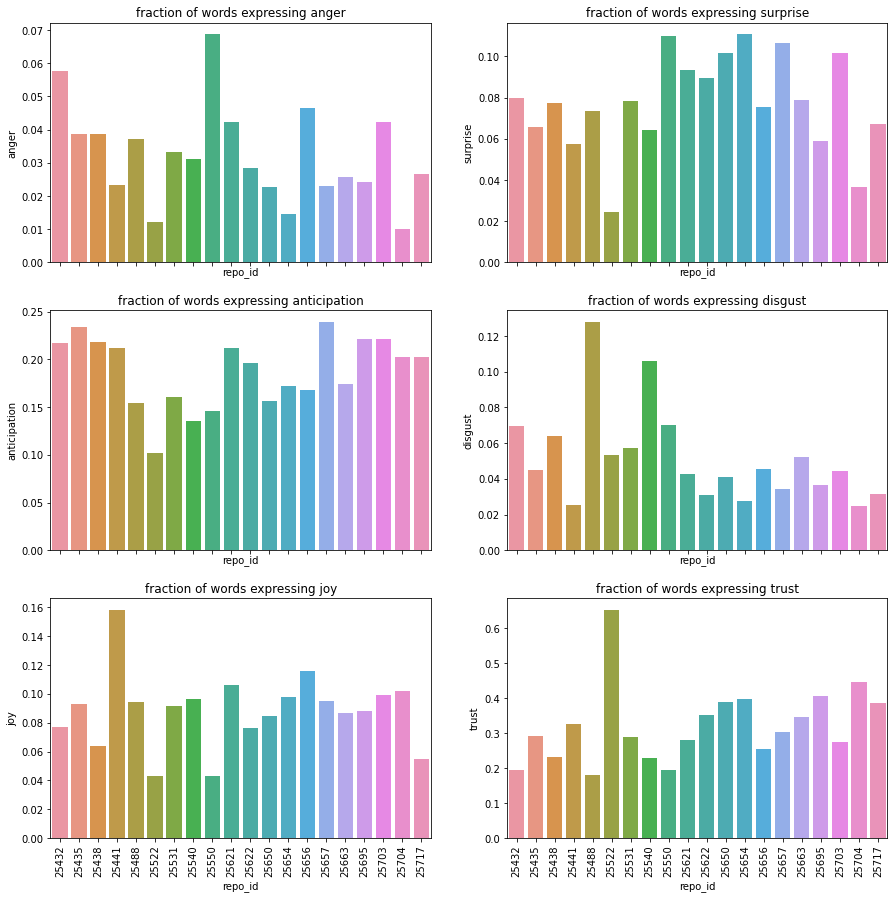

In [335]:

f, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

ax = sns.barplot(x="repo_id", y="anger", data=msg_df_aug_emo_sub, ax=axes[0,0])
ax.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
ax.set_title("fraction of words expressing anger")

ax = sns.barplot(x="repo_id", y="surprise", data=msg_df_aug_emo_sub, ax=axes[0,1])
ax.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
ax.set_title("fraction of words expressing surprise")


ax = sns.barplot(x="repo_id", y="anticipation", data=msg_df_aug_emo_sub, ax=axes[1,0])
ax.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
ax.set_title("fraction of words expressing anticipation")

ax = sns.barplot(x="repo_id", y="disgust", data=msg_df_aug_emo_sub, ax=axes[1,1])
ax.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
ax.set_title("fraction of words expressing disgust")

ax = sns.barplot(x="repo_id", y="joy", data=msg_df_aug_emo_sub, ax=axes[2,0])
ax.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
ax.set_title("fraction of words expressing joy")

ax = sns.barplot(x="repo_id", y="trust", data=msg_df_aug_emo_sub, ax=axes[2,1])
ax.set_xticklabels(repo_msg_barplot.get_xticklabels(), rotation=90)
ax.set_title("fraction of words expressing trust")

print()

In [314]:
feature_matrix = msg_df_aug_emo.iloc[:,3:]

In [317]:
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS)
kmeans_model.fit(feature_matrix)
pickle.dump(kmeans_model, open("kmeans_repo_messages",'wb'))
msg_df_aug_emo['cluster_n'] = kmeans_model.labels_.tolist()
msg_df_aug_emo

,repo_id,msg_text,cluster,DT,NN,VBZ,VBG,IN,PRP,RB,...,WP,anger,surprise,anticipation,disgust,fear,joy,sadness,trust,cluster_n
0,25432,The patch is working for me locally (after bui...,0,0.091559,0.185853,0.039502,0.020186,0.097167,0.051626,0.058663,...,0.002545,0.057557,0.079670,0.216844,0.069566,0.146273,0.077131,0.158335,0.194625,3
1,25435,Thanks for confirming my hypothesis @lukebakke...,0,0.100954,0.171255,0.034341,0.027984,0.091538,0.055882,0.059072,...,0.002918,0.038617,0.065706,0.234236,0.045072,0.118386,0.093141,0.114352,0.290490,3
2,25438,Changes made and moved to 4.x.x branch on #346...,0,0.100614,0.191801,0.041726,0.021012,0.096066,0.049129,0.056664,...,0.002490,0.038595,0.077624,0.217693,0.063747,0.168690,0.064180,0.136600,0.232871,3
3,25441,"Hi Simon, this seems to correlate with what Si...",0,0.070694,0.213809,0.031589,0.018638,0.077042,0.050024,0.046520,...,0.003479,0.023176,0.057626,0.211713,0.025368,0.094895,0.158472,0.102412,0.326339,0
4,25488,Would it improve the situation to write out al...,0,0.095252,0.198029,0.031451,0.019917,0.088953,0.064578,0.051573,...,0.002413,0.037037,0.073593,0.153920,0.127946,0.173160,0.094276,0.160173,0.179894,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,30064,"Well, there could also be other variables that...",3,0.075837,0.215414,0.024239,0.020737,0.077387,0.052893,0.042238,...,0.001592,0.060296,0.063873,0.147675,0.052632,0.107052,0.154318,0.121615,0.292540,3
93,30067,Don't worry. I found the instructions on the ...,3,0.070288,0.220448,0.025192,0.018831,0.073026,0.050110,0.038756,...,0.001369,0.077094,0.098768,0.170690,0.097291,0.142611,0.067734,0.171921,0.173892,3
94,30073,"Hi @andresbono, thanks for your review.\r\nI a...",3,0.063768,0.232657,0.023207,0.018520,0.065393,0.040165,0.032665,...,0.001229,0.051424,0.076583,0.191319,0.064971,0.140448,0.110312,0.157589,0.207354,3
95,30109,"> to force it to use embedded lib\r\n\r\nOh, i...",3,0.101629,0.193455,0.036917,0.023318,0.102507,0.062218,0.064287,...,0.004675,0.051490,0.058938,0.141192,0.093912,0.168394,0.084521,0.157707,0.243847,3


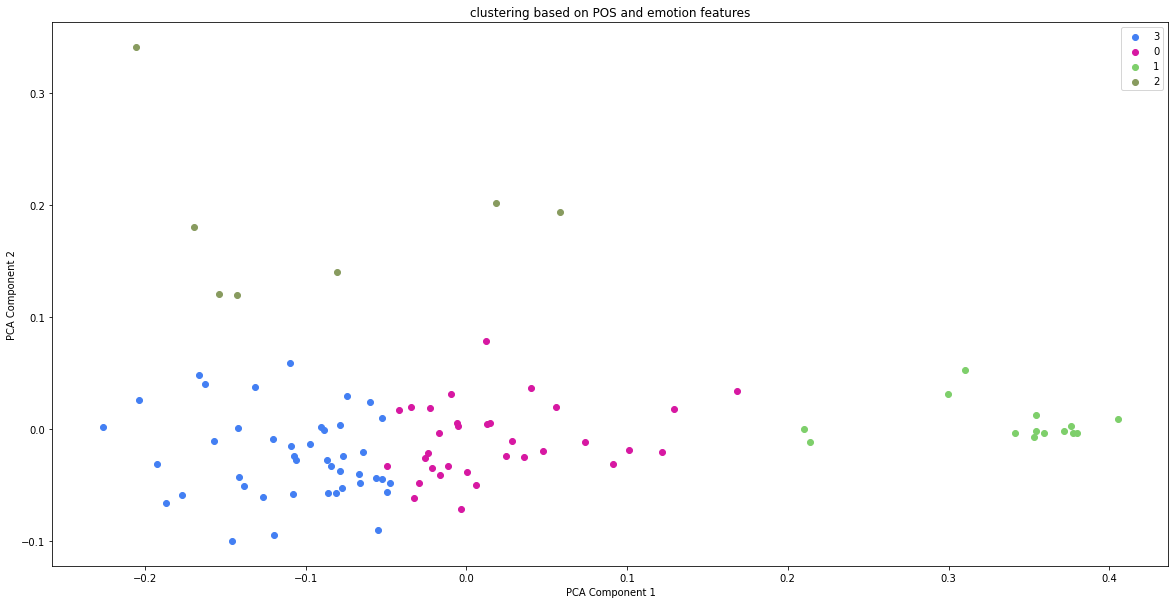

In [322]:
visualize_labels_PCA(feature_matrix, msg_df_aug_emo['cluster_n'], msg_df_aug_emo['repo_id'], 2, "clustering based on POS and emotion features".format(MIN_DF, MAX_DF, NGRAM_RANGE))

In [332]:
result_content_emo = result_content_df[['repo_id','repo_name','repo_git', 'cluster']].set_index('repo_id').join(msg_df_aug_emo[['repo_id','cluster_n']].set_index('repo_id')).reset_index()
result_content_emo.columns = ['repo_id', 'repo_name', 'repo_git', 'cluster_content', 'cluster_mechanism']
result_content_emo.sample(n=10)

,repo_id,repo_name,repo_git,cluster_content,cluster_mechanism
13,25656,spring-amqp,https://github.com/Spring-projects/spring-amqp,3,3
42,26978,LicenseFinder,https://github.com/pivotal/LicenseFinder,2,1
15,25663,spring-framework,https://github.com/Spring-projects/spring-fram...,1,0
93,30067,bitnami-docker-phabricator,https://github.com/bitnami/bitnami-docker-phab...,3,3
35,25857,gpdb,https://github.com/greenplum-db/gpdb,3,3
3,25441,rabbitmq-management,https://github.com/rabbitmq/rabbitmq-management,0,0
14,25657,spring-batch,https://github.com/Spring-projects/spring-batch,1,0
71,27962,concord-bft,https://github.com/vmware/concord-bft,3,0
96,30125,kube-prod-runtime,https://github.com/bitnami/kube-prod-runtime,3,3
30,25800,spring-restdocs,https://github.com/Spring-projects/spring-rest...,1,0


In [178]:
def text_to_feature_matrix(text_list):
    count_dicts =  text_list.apply(lambda x : count_func(x))
    emo_dicts   =  text_list.apply(lambda x : emotion_count(x))
    feature_dicts = []
    for i in range(0, len(count_dicts)):
        count_dicts[i].update(emo_dicts[i])
        feature_dicts.append(count_dicts[i])
    return pd.DataFrame.from_records(feature_dicts)
    

In [179]:
repo_id_test = msg_df_aug_emo['repo_id'][:1]
feature_matrix_test = text_to_feature_matrix(msg_df_aug_emo['msg_text'][:1])
feature_matrix_test.isna().any()
#feature_matrix_test = feature_matrix_test.dropna(axis='columns')
#feature_matrix_test

PRP             False
VBP             False
VBG             False
NNS             False
TO              False
NNP             False
RB              False
VB              False
NN              False
IN              False
JJ              False
WP              False
MD              False
CD              False
DT              False
VBZ             False
VBD             False
VBN             False
CC              False
WDT             False
WRB             False
JJR             False
PRP$            False
EX              False
anger           False
surprise        False
anticipation    False
disgust         False
fear            False
joy             False
sadness         False
trust           False
dtype: bool

In [180]:
prediction = kmeans_model.predict(feature_matrix_test)
print(repo_id_test,prediction)

0    25432
Name: repo_id, dtype: int64 [0]
